In [3]:
%matplotlib inline
%load_ext iminizinc
from IPython.display import HTML
import ipywidgets as widgets

from problems import nqueens, us_map_coloring
from draw_utils import draw_nqueens, draw_us_map
from backtracking_search import nqueens_backtracking

HTML('<script src="http://d3js.org/d3.v3.min.js" charset="utf-8"></script>')

<IPython.core.display.Javascript object>

MiniZinc to FlatZinc converter, version 2.2.3, build 34907429
Copyright (C) 2014-2018 Monash University, NICTA, Data61


# Constraint Programming
Topics: constraint propagation, search, variable elimination; global constraints; MVRP

## Introduction

Constraints naturally arise in a variety of interactions and fields of study such as game theory, social studies, operations research, engineering, and artificial intelligence. A constraint refers to the relationship between the state of objects, such as the constraint that the three angles of a triangle must sum to 180 degrees. Note that this constraint has not precisely stated each angle's value and still allows some flexibility. Said another way, the triangle constraint restricts the values that the three variables (each angle) can take, thus providing information that will be useful in finding values for the three angles.

Another example of a constrained problem comes from the recently-aired hit TV series *Buddies*, where a group of five (mostly mutual) friends would like to sit at a table with three chairs in specific arrangements at different times, but have requirements as to who they will and will not sit with.

Another example comes from scheduling: at the university level, there is a large number of classes that must be scheduled in various classrooms such that no professor or classroom is double booked. Further, there are some constraints on which classes can be scheduled for the same time, as some students will need to be registered for both.

Computers can be employed to solve these types of problems, but in general these tasks are computationally intractible and cannot be solved efficiently in all cases with a single algorithm \cite{Dechter2003}. However, by formalizing these types of problems in a constraint processing framework, we can identify classes of problems that can be solved using efficient algorithms.

Below, we discuss generally the three core concepts in constraint programming: **modelling**, **inference**, and **search**. Modelling is an important step that can greatly affect the ability to efficienctly solve constrained problems and inference (e.g., constraint propagation) and search are solution methods. Basic constraint propagation and state-space search are building blocks that state of the art solvers incorporate.

### Modelling

A **constraint satisfaction problem** (CSP) is formalized by a *constraint network*, which is the triple $\mathcal{R} = \langle X,D,C\rangle$, where
- $X = \{x_i\}_{i=1}^n$ is the set of $n$ variables
- $D = \{D_i\}_{i=1}^n$ is the set of variable domains, where the domain of variable $x_k$ is $D_k$
- $C = \{C_i\}_{i=1}^m$ is the set of constraints on the values that each $x_i$ can take on. Specifically,
    - Each constraint $C_i = \langle S_i,R_i\rangle$ specifies allowed variable assignments.
    - $S_i \subset X$ contains the variables involved in the constraint, called the *scope* of the constraint.
    - $R_i$ is the constraint's *relation* and represents the simultaneous legal value assignments of variables in the associated scope.
        - For example, if the scope of the first constraint is $S_1 = \{x_3, x_8\}$, then the relation $R_1$ is a subset of the Cartesian product of those variables' domains: $R_1 \subset D_3 \times D_8$, and an element of the relation $R_1$ could be written as a 2-tuple $(a,b)\in R_1$.

Each variable in a CSP can be assigned a value from its domain. A **complete assignment** is one in which every variable is assigned and a **solution** to a CSP is a consistent (or legal w.r.t. the constraints) complete assignment. 

Note that for a CSP model, *any* consistent complete assignment of the variables (i.e., where all constraints are satisfied) constitutes a valid solution; however, this assignment may not be the "best" solution. Notions of optimality can be captured by introducing an objective function which is used to find a valid solution with the lowest cost. This is referred to as a **constraint *optimization* problem** (COP). We will refer generally to CSPs with the understanding that a CSP can easily become a COP by introducing a heuristic.

In this notebook, we will restrict ourselves to CSPs that can be modelled as having **discrete, finite domains**. This helps us to manage the complexity of the constraints that need to be managed. In a general CSP, the *arity* of each constraint is allowed to be anything. We can have unary constraints on a single variable, binary constraints between two variables, or $n$-ary constraints between $n$ variables. However, having more than binary constraints adds complexity to the algorithms for solving CSPs. It can be shown that every finite-domain constraint can be reduced to a set of binary constraints by adding enough auxiliary variables \cite{AIMA}. THerefore, since we are only discussing CSPs with finite domains, we will assume that the CSPs we are working with have only unary and binary constraints.

### Modelling as a Graph

An important view of the constraint network that defines a CSP is as a graph, $\langle\mathcal{V},\mathcal{E}\rangle$. In particular, the each vertex corresponds to a variable, $\mathcal{V} = X$, and the edges of the graph $\mathcal{E}$ correspond to various constraints between variables. Since we are only working with binary and unary constraint networks, it is easy to visualize a graph corresponding to a CSP.

For example, consider a CSP $\mathcal{R}$ with the following definition
\begin{align}
X &= \{x_1, x_2, x_3\} \\
D &= \{D_1, D_2, D_3\},\  \text{where}\; D_1 = \{0,5\},\ D_2 = \{1,2,3\},\ D_3 = \{7\} \\
C &= \{C_1, C_2, C_3\},
\end{align}
where
\begin{align}
C_1 &= \langle S_1, R_1 \rangle = \langle \{x_1\}, \{5\} \rangle \\
C_2 &= \langle S_2, R_2 \rangle = \langle \{x_1, x_2\}, \{(0, 1), (0,3), (5,1)\} \rangle \\
C_3 &= \langle S_3, R_3 \rangle = \langle \{x_2, x_3\}, \{(1, 7), (2, 7)\} \rangle.
\end{align}
The graphical model of this CSP is shown below.

<img src="images/example_graph.png" width="35%" align="center"/>


### Solving

The goal of formalizing a CSP as a constraint network model is to efficiently solve it using computational algorithms and tools. **Constraint programming** (CP) is a powerful tool to solve combinatorial constraint problems and is the study of computational systems based on constraints. Once the problem has been modeled as a formal CSP, a variety of computable algorithms could be used to find a solution that satisfies all constraints.

In general, there are two methods used to solve a CSP: search or inference. In previous 16.410/413 problems, **state-space search** was used to find the best path through some sort of graph or tree structure. Likewise, state-space search could be used to find a valid "path" through the CSP that satisfies each of the local constraints and is therefore a valid global solution. However, this approach would quickly become intractable as the number of variables and the size of each of their domains increase.

In light of this, the second solution method becomes more attractive. **Constraint propagation**, a specific type of inference, is used to reduce the number of legal values from a variable's domain by pruning values that would violate the constraints of the given variable. By making a variable locally consistent with its constraints, the domain of adjacent variables may potentially be further reduced as a result of missing values in the pairwise constraint of the two variables. In this way, by making the first variable consistent with its constraints, the constraints of neighboring variables can be re-evaluated, causing a further reduction of domains through the propagation of constraints. These ideas will later be formalized as $k$-consistency.

Constraint propagation may be combined with search, using the pros of both methods simultaneously. Alternatively, constraint propagation may be performed as a pre-processing pruning step so that search has a smaller state space to search over. Sometimes, constraint propagation is all that is required and a solution can be found without a search step at all.

After giving examples of modelling CSPs, this notebook will explore a variety of solution methods based on constraint propagation and search.

---

## Modeling

Given a constrained problem, it is desirable to identify an appropriate constraint network model $\mathcal{R} = \langle X,D,C\rangle$ that can be used to find its solution. Modelling for CSPs is an important step that can dramatically affect the difficulty in enumerating the associated constraints or efficiency of finding a solution.

Using the general ideas and formalisms from the previous section, we consider two puzzle problems and model them as CSPs in the following sections.

### N-Queens

The N-Queens problem (depicted below for 8 queens) is a well-know puzzle among computer scientists and will be used as a recurring example throughout this notebook. The problem statement is as follows: given any integer $N$, the goal is to place $N$ queens on an $N\times N$ chessboard satisfying the constraint that no two queens threaten each other. A queen can threaten any other queen that is on the same row, column, or diagonal.


In [8]:
# Example n-queens
draw_nqueens(nqueens(4))

<IPython.core.display.Javascript object>

Now let's try to understand the problem formally.

#### Attempt 1

To illustrate the effect of modelling, we first consider a (poor) model for the N-Queens constraint problem, given by the following definitions:
\begin{align}
X &= \{x_i\}_{i=1}^{N^2}                      && \text{(Chessboard positions)} \\
D &= \{D_i\}_{i=1}^{N^2},\ \text{where}\; D_i = \{0, 1,2,\dots,N\}  && \text{(Empty or the $N^\text{th}$ queen)}
\end{align}

Without considering constraints, the size of the state space (i.e., the number of assignments) is an enormous $(N+1)^{N^2}$. For only $N=4$ queens, this becomes $5^{16} \approx 153$ billion states that could potentially be searched.

<div class="alert alert-info">
Although somewhat of an aside, we take this opportunity to stress the infeasibility of simply performing a state-space search and then performing a goal test that encodes the problem constraints. This motivates the idea of efficiently using constraints either before or during our solution search, which we will explore in the following sections.
</div>

Expressing the constraints of this problem in terms of the variables and their domains also poses a challenge. Because of the way we have modelled this problem, there are five primary constraints to satisfy:
1. Exactly $N$ chess squares may be filled (i.e., there are only $N$ queens and all of them must be used)
1. No queens share a column
1. No queens share a row
1. No queens share a positive diagonal (i.e., a diagonal from bottom left to top right)
1. No queens share a negative diagonal (i.e., a diagonal from top left to bottom right)

To express these constraints mathematically, we first let $Z \triangleq \{x\in X|x\ne 0\}$ be the set of non-empty chess squares. With pointers back to which constraint they satisfy, the expressions, $\forall z_i, z_j \in Z, i\ne j$, are:
\begin{align}
|Z| &= N && (C1) \\
|z_i-z_j| &\ne N && (C2) \\
\left\lfloor\frac{z_i-1}{N}\right\rfloor &\ne \left\lfloor\frac{z_j-1}{N}\right\rfloor && (C3) \\
|z_i-z_j| &\ne (N-1) && (C4) \\
|z_i-z_j| &\ne (N+1), && (C5)
\end{align}
where applying $|\cdot|$ to a set is the set's cardinalilty (i.e., size) and applied to a scalar is the absolute value. Additionally, we use $\lfloor\cdot\rfloor$ as the floor operator. Notice how we are able to express all the constraints as pairwise (binary).

#### Attempt 2

Motivated by the desire to do less work in searching and writing constraints, we consider the following model of the N-Queens problem where we encode the following assumptions:
1. assume one queen per column;
1. an assignment determines which row the $i^\text{th}$ queen should be in.

With this understanding, we can write the constraint network as
\begin{align}
X &= \{x_i\}_{i=1}^{N}                      && \text{(Queen $i$ in the $i^\text{th}$ column)} \\
D &= \{D_i\}_{i=1}^{N},\ \text{where}\; D_i = \{1,2,\dots,N\}  && \text{(The row in which the $i^\text{th}$ queen should be placed)}.
\end{align}

Now considering the size of the state space without constraints, we see that this intelligent encoding reduces the size to only $N^N$ assignments.

Writing down the constraints is also easier for this model. In fact, we only need to address constraints (C3)-(C5) from above, as (C1) and (C2) are taken care of by intelligently choosing our variables and their domains. The expressions, $\forall x_i,x_j\in X, i\ne j$, are
\begin{align}
x_i &\ne x_j && \text{(C3)} \\
|x_i-x_j| &\ne |i-j|. && \text{(C4, C5)}
\end{align}

We have successfully modelled the N-Queens problem with a reduced state space and with only two constraints. Both of these properties will allow the solvers discussed next to more efficiently find solutions to this CSP.

#### First MiniZinc model

Let us now introduce [MiniZinc](https://www.minizinc.org/), a **high-level**, **solver-independent** language to express constraint programming problems and solve them. It has a large library of constraints already encoded that we can exploit to encode our problem.

A very useful constraint is `alldifferent(array[int] of var int: x)`, which is one of the most studied and used constraint in constraint programming. As the name suggest it takes an array of variables and constrains them to take different values.

Now the reader can notice that we can write (C1), (C2) and (C3) of out N-Queens leveraging the `alldifferent` constraint. As result we get the following model. 

In [9]:
%%minizinc
include "globals.mzn";

int: n = 4;
array[0..n-1] of var 1..n: queens;

constraint all_different(queens);
constraint all_different([queens[i]+i | i in 0..n-1]);
constraint all_different([queens[i]-i | i in 0..n-1]);

solve satisfy;

{'queens': [2, 4, 1, 3]}

Here we are asking MiniZinc to solve find any feasible solution (`solve satisfy`) given the constraints.

### Map Coloring \label{subsec:map_coloring}

Map coloring is another classic example of a CSP. Consider the map of Australia shown below (stolen from \cite{AIMA}). The goal is to assign a color to Australia's sevem territories such that no neighboring regions share the same color. We are further constrained by only being able to use three colors (e.g., <span style="color:red;font-weight:bold">R</span>, <span style="color:green;font-weight:bold">G</span>, <span style="color:blue;font-weight:bold">B</span>). Next to the map is the constraint graph representation of this specific map-coloring problem.

<table width="70%">
<tr>
    <td><img src="images/mapcoloring_map.png" align="center"/></td>
    <td><img src="images/mapcoloring_graph.png" align="center"/></td>
</tr>
</table>

The constraint network model $\mathcal{R}=\langle X,D,C \rangle$ for the general map-coloring problem with $N$ regions and $M$ colors is defined as:
\begin{align}
X &= \{x_i\}_{i=1}^N && \text{(Each region)} \\
D &= \{D_i\}_{i=1}^N,\ \text{where}\; D_i = \{c_j\}_{j=1}^M,   && \text{(Available colors)}
\end{align}
and the constraints are encoded as
\begin{align}
\forall x_i\in X: x_i &\ne n_j,\ \forall n_j\in\mathcal{N}(x_i), && \text{(Each region cannot have the same color as any of its neighbors)}
\end{align}
where the neighborhood of the region $x_i$ is defined as the set $\mathcal{N}(x_i) = \{x_j\in X| A_{ij}=1,i\ne j, \forall j\}$. The matrix $A\in\mathbb{Z}_{\ge 0}^{N\times N}$ is called the *adjacency matrix* of a graph with $N$ vertices and represents the variables that a given variable is connected to by constraints (i.e., edges). The notation $A_{mn}$ indexes into the matrix by row $m$ and column $n$.

We will use the map coloring problem as a COP example later on.

---

## Constraint Propagation Methods

As previously mentioned, the domain size of a CSP can be dramatically reduced by removing values from variable domains that would violate the relevant constraints. This idea is called **local consistency**. By representing a CSP as a binary constraint graph, making a graph locally consistent amounts to visiting the $i^\text{th}$ node and for each of the values in the domain $D_i$, removing the values of neighboring domains that would cause an illegal assignment.

A great example of the power of constraint propagation is seen in Sudoku puzzles. These puzzles are designed to be solved by constraint propagation alone. By enforcing local consistency throughout the puzzle, the unique solution is found without the need for search.

While there are multiple forms of consistency, we will forgo a discussion of node consistency (single node), path consistency (3 nodes), and generally **$k$-consistency** ($k$ nodes) to focus on arc consistency.

### Arc Consistency

The most well-known notion of local consistency is **arc consistency**, where the key idea is to remove values of variable domains that can never satisfy a specified constraint. The arc $\langle x_i, x_j \rangle$ between two variables $x_i$ and $x_j$ is said to be arc consistent if $\langle x_i, x_j \rangle$ and $\langle x_j, x_i \rangle$ are *directed* arc consistent.

The arc $\langle x_i, x_j \rangle$ is **directed arc consistent** (from $x_i$ to $x_j$) if $\forall a_i \in D_i \; 
\exists a_j \in D_j$ s.t. $\langle a_i, a_j \rangle \in C_{ij}$.

As an example, consider the following simple constraint network:
\begin{align}
X &= \{x_1, x_2\} \\
D &= \{D_1, D_2\},\ \text{where}\; D_1=\{1,3,5,7\}, D_2=\{2,4,6,8\} \\
C &= \{C_{12}\},
\end{align}
where $C_{12} = \{(1,2),(3,8),(7,4)\}$ lists legal assignment relationships between $x_1$ and $x_2$.

To make $\langle x_1, x_2 \rangle$ directed arc consistent, we would remove the values from $D_1$ that could never satisfy the constraint $C_{12}$. The original domains are shown on the left, while the directed arc consistent graph is shown on the right.

<table width="70%">
<tr style="background-color:white">
    <td><img src="images/directedac_1a.png" align="center"/></td>
    <td><img src="images/directedac_1b.png" align="center"/></td>
</tr>
</table>

Similarly, we can make $\langle x_2, x_1 \rangle$ directed arc consistent by removing 6 from $D_2$. This results in an arc consistent graph, shown below.

<img src="images/example_ac.png" width="35%"/>

#### Sound but Incomplete
By making a CSP arc consistent, we are guaranteed that solutions to the CSP will be found in the reduced domain of the arc consistent CSP. However, we are not guaranteed that any arbitrary assignment of variables from the reduced domain will offer a valid CSP solution. In other words, arc consistency is sound (all solutions are arc-consistent solutions) but incomplete (not all arc-consistent solutions are valid solutions).

### Algorithms

To achieve arc consistency in a graph, we can formalize the ideas that we discussed above about removing values from domains that will never participate in a legal constraint. Two widespread algorithms are considered, known `AC-1` and `AC-3`, which are the first and third versions described by Mackworth in \cite{Mackworth1977}.

In this section, we give the pseudocode for these algorithms and a dicussion of their complexities and trade offs.

#### The `REVISE` Algorithm

First, we formalize the procedure of achieving local consistency via the `REVISE` procedure, which is an algorithm that enforces directed arc consistency on a subnetwork. This is the algorithm that we used in the toy example above with $x_1$ and $x_2$.

```vhdl
1  procedure REVISE(xi,xj)
2  for each ai in Di
3    if there is no aj in Dj such that (ai,aj) is consistent,
4       delete ai from Di
5    end if
6  end for
7  end
```

##### Complexity Analysis

The complexity of `REVISE` is $O(k^2)$, where $k$ bounds the domain size, i.e., $k=\max_i|D_i|$. The $k^2$ comes from the fact that there is a double `for loop`---the outer loop is on line 2 and the inner loop is on line 3.

#### The `AC-1` Algorithm

A first pass of enforcing arc consistency on an entire constraint network would be to revise each variable domain in a brute-force manner. This is the objective of the following `AC-1` procedure, which takes a CSP definition $\mathcal{R}=\langle X, D, C\rangle$ as input.

```vhdl
1  procedure AC1(csp)
2    loop
3      for each cij in C
4        REVISE(xi, xj)
5        REVISE(xj, xi)
6      end for
7    until no domain is changed
8  end
```

If after the `AC-1` procedure is run any of the variable domains are empty, then we conclude that the network has no solution. Otherwise, we are guaranteed an arc-consistent network.

##### Complexity Analysis

Let $k$ bound the domain size as before and let $n=|X|$ be the number of variables and $e=|C|$ be the number of constraints. One cycle through all of the constraints (lines 3-6) takes $O(2*e*O_\text{REVISE}) = O(ek^2)$. In the worst case, only a single domain is changed in one cycle. In this case, the maximum number of repeats (line 7) will be the total number of values, $nk$. Therefore, the worst-case complexity of the `AC-1` procedure is $O(enk^3)$.

#### The `AC-3` Algorithm

Clearly, `AC-1` is straightforward to implement and generates an arc-consistent network, but at great expense. The question we must ask ourselves when using any brute-force method is: Can we do better?

A key observation about `AC-1` is that it processes all constraints even if only a single domain was reduced. This is unnecessary because changes in a domain typically only affect a local subgraph around the node in question.

The `AC-3` procedure is an improved version that maintains a queue of ordered pairs of variables that participate in a constraint (see lines 2-4). Each arc that is processed is removed from the queue (line 6). If the domain of the arc tail $x_i$ is revised, arcs that have $x_i$ as the head will need to be re-evaluated and are added back to the queue (lines 8-10).

```vhdl
 1  procedure AC3(csp)
 2    for each cij in C do
 3      Q ← Q ∪ {<xi,xj>, <xj,xi>};
 4    end for
 5    while Q is not empty
 6      select and delete any arc (xi,xj) from Q
 7      REVISE(xi,xj)
 8      if REVISE(xi,xj) caused a change in Di
 9        Q ← Q ∪ {<xk,xi> | k ≠ i, k ≠ j, ∀k }
10      end if
11    end while
12  end
```

##### Complexity Analysis

Using the same notation as before, the time complexity of `AC-3` is computed as follows. Building the initial `Q` is $O(e)$. We know that `REVISE` is $O(k^2)$ (line 7). This algorithm processes constraints at most $2k$ times since each time it is reintroduced into the queue (line 9), the domain of one of its associated variables has just been revised by at least one value, and there are at most $2k$ values. Therefore, the total time complexity of `AC-3` is $O(ek^3)$.

Note that the optimal algorithm has complexity $O(ek^2)$ since the worst case of merely verifying the arc consistency of a network requires $ek^2$ operations. There is an `AC-4` algorithm that achieves this performance by not using `REVISE` as a block box, but by exploiting the structures at the constraint level \cite{Dechter2003}.

### Example

<div class="alert alert-danger">
    <b>TODO:</b> Show example of arc consistency with N-Queens (or map coloring ?)
</div>

---

## Search Methods

Here we investigate using search methods for solving CSPs. As mentioned previously, a simple state-space search would be intractable as the number of variables and their domains increase. However, we will first examine state-space search in more detail and then move to a more clever search algorithm called backtrack search (BT) that checks consistency along the way.

We will use the map coloring example shown below to explain how to perform search.

<img src="images/search_mapcoloring.png" width="40%" />

### Generic Search for CSPs

As we have studied before, a generic search problem can be specified by the following four elements: (1) state space, (2) initial states, (3) operator, and (4) goal test. In a CSP, consider the following definitions of these elements:
- state space
    - partial assignment to variables at the current iteration of the search
- initial state
    - no assignment
- operator
    - add a new assignment to any unassigned variable, e.g., $V_i = a$, where $a\in D_k$.
    - child extends parent assignments with new
- goal test
    - all variables are assigned
    - all constraints are satisfied
    
With this definition of a generic state-space search of CSP solutions, note that the branching factor is the sum of the domain size for all variables, $O(nk)$. The performance is exponential in the branching factor, $O([nk]^n)$.
    
With a better understanding of how expensive it can become to solve interesting problems with a simple state-space search, we are motivated to find a better searching algorithm.

### Backtrack Search

Backtrack (BT) search is based on depth-first search (DFS) to choose values for one variable at a time, but it backtracks whenever there are no legal values left to assign.

#### Algorithm

<div class="alert">
<pre>
<b>procedure backtrack(&lt;V,D,C&gt;)</b>
  <em>input:</em> A constraint network, csp = &lt;V,D,C&gt;
  <em>output:</em> A solution, or notification that the network is inconsistent
<b>Implementation</b>
    if csp.assignment is complete and feasible then 
      return assignment
    var &larr; csp.get_unassigned_var()
    for each value in csp.var_domain(var)
      original_domain = csp.assign(var, value)
      if csp.assignment is feasible then
          result &larr; backtrack(csp)
          if result &ne; failure then
              return result
      csp.unassign(var, value)
      csp.restore_domain(original_domain)
    return failure
<b>end</b>
</pre></div>

#### Example

In [10]:
queens, exec_time = nqueens_backtracking(4)
draw_nqueens([queens.assignment])
print("Solution found in %0.3f seconds" % exec_time)

<IPython.core.display.Javascript object>

Solution found in 0.000 seconds


### Branch and Bound

Suppose we would like to find the *best* solution (in some sense) to the CSP. This amounts to solving the associated constraint optimization problem (COP), where our constraint network is now a 4-tuple, $\langle X, D_X, C, f \rangle$, where $X\in D_X$, $C: D_X \to \{\operatorname{True},\operatorname{False}\}$ and $f: D_x\to\mathbb{R}$ is a cost function. We would like to find the variable assignments $X$ that solve
\begin{array}{ll@{}ll}
\text{minimize}  & f(X) &\\
\text{subject to}& C(X) &
\end{array}

By adding a cost function $f(X)$, we turn a CSP into a COP and we can use the branch and bound algorithm to find the solution with the lowest cost.

#### Example

Now let's revive our discussion on the map coloring problem. Imagine that we work at a company that wishes to print a colored map of the United States, so they need to choose a color for each state. Let's also image that the available colors are:

In [8]:
colors = [
  'red', 
  'green', 
  'blue', 
  '#6f2da8', #Grape
  '#ffbf00', #Amber
  '#01796f', #Pine
  '#813f0b', #Clay
  '#ff2000', #yellow
  '#ff66cc', #pink
  '#d21f3c'  #raspberry
  ]

The CEO asks the engineering department (they have one of course) to find a color assignment that satisfies the constraints as specified above in _Map Coloring_ and they arrive at the following solution:

In [ ]:
map_colors, num_colors = us_map_coloring(colors)
draw_us_map(map_colors)

Num. colors: 5


Unfortunately, management is never happy and they complain that {{ num_colors }} colors are really too many. Can we do better? Yes, by adding an objective function $f$ that gives a cost proportional to the number of used colors, we can minimize $f$. This results in the following solution:

Num. colors: 4


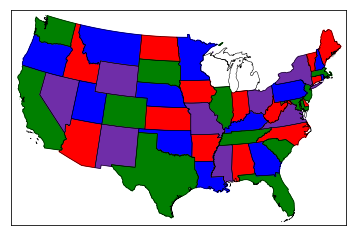

In [18]:
map_colors, opt_num_colors = us_map_coloring(colors, optimize=True)
draw_us_map(map_colors)

Fortunately we saved {{ num_colors - opt_num_colors }} color, well done!

---

## Extended Methods

The methods discussed in this section arise from viewing a CSP from different perspectives and from a combination of constraint propagation and search methods.

### BT Search with Forward Checking (BT-FC)

By interleaving inference from constraint propagation and search, we can obtain much more efficient solutions. A well-known way of doing this is by adding an arc consistency step to the backtracking algorithm. The result is called **forward checking**, which allows us to run search on graphs that have not already been pre-processed into arc consistent CSPs.

In [19]:
queens, exec_time = nqueens_backtracking(4, with_forward_checking=True)
draw_nqueens([queens.assignment])
print("Solution found in %0.4f seconds" % exec_time)

<IPython.core.display.Javascript object>

Solution found in 0.0004 seconds


### BT-FC with Dynamic Variable Ordering

Traditional backtracking as it was introduced above uses a fixed ordering over variables and values. However, it is often better to choose ordering dynamically as the search proceeds. The idea is as follows. At each node during the search, choose:
- the most constrained variable; picking the variable with the fewest legal variables in its domain will minimize the branching factor,
- the least constraining value; choosing a value that rules out the smallest number of values of variables connected to the chosen variable via constraints will leave most options for finding a satisfying assignment.


In [22]:
queens, exec_time = nqueens_backtracking(4, with_forward_checking=True, var_ordering='smallest_domain')
draw_nqueens([queens.assignment])
print("Solution found in %0.4f seconds" % exec_time)

<IPython.core.display.Javascript object>

Solution found in 0.0004 seconds


### Adaptive Consistency: Bucket Elimination

Another method of solving constraint problems entails eliminating constraints through bucket elimination. This method can be understood through the lens of Gaussian elimination, where equations (i.e., constraints) are added and then extra variables are eliminated. More formally, these operations can be thought of from the perspective of relations as join and projection operations.

Bucket elimination uses the join and projection operations on the set of constraints in order to project the constraint graph into a single variable. After solving for that variable, other constraints are solved for by back substitution just as you would in an algebraic system in Gaussian elimination.

<div class="alert alert-danger">
    <b>TODO:</b> N-Queens example
</div>

---

# Symmetries

<img src="images/escher_2.jpg" align="center"/>
<div style="text-align: right"> M. C. Escher </div>


## Introduction

A CSP often exhibit some symmetries, which are mappings that preserve satisfiability of the CSP. They are particularly harmful when we are looking for all possible valid assignment of a CSP since symmetries have many solutions that are just a symmetric solution of another one.

\begin{definition} \label{def:symmetry}
(Symmetry). For any CSP instance $P = \langle X, D, C \rangle$, a solution symmetry of $P$ is a permutation of the set $X\times D$ that preserves the set of solutions to $P$.
\end{definition}


In other words, a solution symmetry is a bijective mapping defined on the set of possible variable-value pairs of a CSP, that maps solutions to solutions.

## Why is symmetry important? 

A principal reason for identifying symmetry in CSPs is to reduce search effort by not exploring assignments that are symmetrically equivalent to assignments considered elsewhere in the search. Clearly, if the solution symmetry group is larger than the constraint symmetry group, there will potentially be a greater search reduction from using the solution symmetries, if they can somehow be identified in advance.


## Case Study: symmetries in N-Queens problem

The standard formulation of the N-Queens problem as a CSP has $N$ variables corresponding to the rows of the chessboard, say $Q_1,Q_2,\ldots,Q_N$. The domain of values corresponds to the columns of the chessboard, say $D = \{1, 2,\ldots, N\}$. The constraints can be expressed as follows:
- the values of $Q_1, Q_2, \ldots, Q_N$ are all different; 
- $\forall i,j,1\leq i< j \leq N,|Q_i−Q_j| \neq |i−j|$.

A chessboard has eight geometric symmetries: 
- horizontal reflection $r_h$
- vertical reflection $r_v$
- reflectins along the two diagonal axes ($r_{d_1}$ and $r_{d_2}$)
- rotations through $90$&deg;, $180$&deg; and $270$&deg; ($r_{90}$, $r_{180}$, $r_{270}$)
- identity (no-reflections) $r_I$

We can group all the symmetries in $G = \{r_I, r_h,r_v, r_{d_1}, r_{d_2},r_{90}, r_{180}, r_{270} \}$
For the seek of simplicity let's denote $A^g$, with $g\in G$ as the result of the application of symmetry $g$ to $A$. For example, in the 4-Queens problem $(Q_1 = 2)^{r_{90}} = (Q_2=4)$.

An example can be given by the 4-Queens problem, all the solutions are the following

<img src="images/two-queens_symmetries.png" align="center"/>

It's easy to note that the second solution is the first solution when we flip the chessboard horizontally.



## Avoid symmetries

### Adding Constraints Before Search

Symmetry in CSPs is usually identified, in practice, by applying human insight: the programmer sees that some transformation would transform a hypothetical solution into another hypothetical solution. Then the programmer can try to formalize some constraint that preserve solutions but remove some of the symmetries.

<div class="alert alert-block alert-danger">
<b>TODO:</b> Example of N-Queens problem with broken symmetries through additional constraints
</div>

This approach is fine if done correctly, but can obviously lose solutions if done incorrectly.


### Dynamic Symmetry Breaking Methods

Dynamic symmetry breaking methods are those that operate to break symmetry during the search process, avoiding some branch of the search tree that are symmetrically equivalent to others. Let's explore some of them.

#### Symmetry Breaking During Search (SBDS)

The basic idea of SBDS (this is the name of the algorithm, not a class for them) is to add constraints to a problem so that, after backtracking from a search decision, the SBDS constraints ensure that no symmetric equivalent of that decision is ever allowed. This is a dynamic technique, since we cannot add the constraints until we know what search decision is being made.

<div class="alert alert-block alert-danger">
<b>TODO:</b> Example search tree for SBDS
</div>

A big drawback of this agorithm is that it always demand from the constraint programmer to explicitly state all symmetries $g\in G$. If a problem has a large number of symmetries there may be too many for the user to identify and implement by hand.

### The Lex-Leader Method

Puget proved that whenever a CSP has symmetry \cite{Puget2003}, it is possible to find a _'reduced form'_, with the symmetries eliminated, by adding constraints to the original problem. Puget found such a reduction for three simple constraint problems, and showed that this reduced CSP could be solved more efficiently than in its original form. From this work a method called **lex-leader** was developed, the background idea is rather simple, for each equivalence class of solutions under our symmetry group, we will predefine one to be the canonical solution. We will achieve this by choosing a static variable ordering. 

For example let's consider a problem where we have three variables $x_1$ $x_2$ and $x_3$ subject to `alldifferent` constraint and domain $\{1,2,3\}$. This problem has $3!$ solutions, the easiest way to impose a canonical solution is to impose that $x_1 \leq x_2 \leq x_3$, that is the _lexicographic_ ordering. Adding this additional constraint we will get exactly one solution. All the other can be recovered applying all the symmetries.

In general the lex-leader method impose a variable ordering for Each permutation in the symmetry group, formally

$$ \forall g \in G, \, A\preceq_{\text{lex }} A^g $$

<div class="alert alert-block alert-danger">
<b>TODO:</b> Example of model with/without lex-leader
</div>

An important practical issue with the lex-leader constraints is that they do not “respect” the variable and value ordering heuristics used in search. That is, it may well be that the leftmost solution in the search tree, which would otherwise be found first, is not canonical and so is disallowed, leading to increased search. This is in contrast to techniques such as SBDS, which do respect the heuristic.

### Double-Lex

A matrix of decision variables has row symmetry iff given a solution, any permutation of the rows is also a solution. Similarly, it has column symmetry iff given a solution, any permutation of the columns is also a solution.  Row and column symmetry occurs in many mod- els with matrices of decision variable. We have seen that that we can add $n!m!$  constraints to break all the symmetries. Adding so many constraints can be counter-productive. A common approach is order the rows of a matrix and **independently** order the columns. This produces only $n + m − 2$ symmetry breaking constraints. This method is called **double-lex** and has the disadvantage of breaking only some of the symmetries.

<div class="alert alert-block alert-danger">
<b>TODO:</b> Example of the same model as before but with double-lex
</div>

## Intractability of Breaking Symmetry


It is worth to mention that lex-leader requires one constraint for each element of the group. 
In the case of a matrix with $m$ rows and $n$ columns, this is $m!n!$, which is impractical in general. Therefore there are many cases where lex-leader is applicable but impractical.

\begin{theorem} \label{theo:simple_ordering_NP}
(Walsh 2011) Given any _simple_ ordering, there exists a symmetry group such that deciding if an assignment is smallest in its symmetry class according to this ordering is NP-hard.
\end{theorem}


Since breaking symmetry appears intractable in general, a major research direction is to identify special cases which occur in practice where the symmetry group is more tractable to break.

\begin{theorem} \label{theo:lex2_NP}
(Katsirelos, Narodytska, and Walsh 2010) Propagating the double-lex constraint is NP-hard.
\end{theorem}

## Partial Symmetry Breaking

If we are trying to solve a problem that is exponentially symmetric we may not be able to fully utilize a given symmetry breaking technique.

By only describing a subset of symmetries we are performing partial symmetry breaking (PSB) i.e. performing some redundant search because the symmetry breaking technique is too costly
or even impossible to perform. 

The problem with this approch is that is it hard to select wih simmetry constraint to remove, for this reason there are a class of algorithms that use heuristics to 

## Symmetry Breaking by Nonstationary Optimisation

Suppose that we are solving a problem using depth-first search (DFS) with static variable ordering, and constraint processing.
If we can apply a group element $g ∈ G$ to the current partial assignment $A$ such that $A^g\prec_{\text{lex }} A$, then under the above assumptions $A^g$ dominates (symmetrically equivalent to) $A$ and we can backtrack from $A$.

<div class="alert alert-block alert-danger">
<b>TODO:</b> Graphical example
</div>

### Detection as nonstationary optimisation

We can model the detection problem as an optimisation problem with $G$ as the search space, so that each $g ∈ G$ is a search state. The objective function of $g$ to be minimised is the lex-ranking of $A^g$. On finding an element $g$ with sufficiently small objective value we have solved the detection problem.

### Detection by local search

To make SBNO more concrete we can use local search for detection. 
In this contex $G$ is the search space the lex-ranking of $A^g$ is the objective function. Local search requires a neighbourhood structure defining the possible local moves from each search state. 

To impose a neighbourhood structure on $G$ we choose some subset $H \subset G$: from any search state $g$ the possible local moves are the elements of $H$ leading to neighbouring states $g \odot H$. Thus all $G$ elements are local search states, and some of them ($H$) are also local moves. 


To apply hill climbing, from each state g we try to find a local move $h$ such that the objective function is reduced ($A^{g\odot h} \prec_{\text{lex}} A^g$). If a series of moves $h_1, h_2, \ldots$ reduces the lex-ranking sufficiently then we will find $A^{g\odot h_1\odot h_2 \odot\ldots} \prec_{\text{lex}} A$ and can backtrack from $A$.

<div class="alert alert-block alert-danger">
<b>TODO:</b> Algorithm pseudocode
</div>

## Reduce the set of Symmetry breaking constraints

When we are dealing with symmetries we always have a tradeoff between the size of the search tree and the propagation effort. Using lex-leader adds too many contraints, double-lex is better but might leave a lot of symmetries.

We can think of an extension of double-lex that breaks more symmetries, examples are:

- $\text{lex}^+$ also called _swap-next_, considers a pair of adjacent rows and a pair of adjacent columns
    - $mn -1 $ constraints
- $\text{lex}^*$ also called _swap-any_, considers any pair of rows and any pair of columns
    - $O(m^2n^2)$ constraints

### Lex constraint decomposition

We can decompose the lex constraint of the form $x_1\ldots x_2 \preceq_{\text{lex }} y_1\ldots y_2$ to a conjunction of clauses like
$$ \left(x_1 = y_1 \right),\ldots,\left(x_k = y_k\right)\rightarrow x_{k+1}\leq y_{k+1} $$
We call clauses of this form lex implications.

According to \cite{Codish2018} roughly 65% of the lex implications of $\text{lex}^*$ are redundant. So we can try to develop an algorithm that tries to remove all redundant constraints. Given this observation, we can pose the direct question: how many lex implications are required to express a complete symmetry break.

### Reduce implications

Basically, the algorithm iterates over the set of lex implications, and checks for each of them if they are redundant. This is done by removing them from the formula, and checking if there is a solution which would be forbidden by this clause, as shown in Algorithm 2. If this is not the case, the clause is redundant and can be removed. This is accomplished by running a SAT solver on the implication.

The reduction splits in two phases. 

1. The first phase is shown in Algorithm 1. We check if a clause $c$ is redundant. If this is the case, we compute a subset $\psi\subseteq\varphi^\prime$ of clauses which makes $c$ redundant, and increase the ranking of all clauses within this set. The rationale is that removing these clauses is more likely make other clauses no longer redundant, and so increase the size of the final symmetry break.
2. In the second stage, we sort the clauses by ranking, so clauses which were frequently the cause of redundancy appear as late as possible. We then reduce the set of lex implications using Algorithm 2.

<div class="alert alert-warning">
<img src="images/rm_symmetries.png" align="center"/>
</div>

<div class="alert alert-danger">
<b>TODO:</b> fix notation, $\phi$ is the set of constraints
</div>

### Example

The number of solutions for Boolean matrix models with various symmetry breaks.

| n | None | $\text{lex}^2$ |  $\text{lex}^+$ | $\text{lex}^*$ | Complete |
|:--|-----:|---------------:|----------------:|---------------:|---------:|
| 3 |$2^9$| 45 | 37 | 36 | 36 | 
| 4 |$2^{16}$| 650 | 366 | 330 | 317 | 
| 5 |$2^{25}$| 24520 | 8659 | 6779 | 5624 |
| 6 |$2^{36}$| 2625117 | 602813 | 391532 | 251610 |
| 7 |$2^{49}$| 836488618 | 139268908 | 73720859 | 33642660 |

Number of lex implications for  $\text{lex}^*$ for matrix models before and after reduction.

| n | Before | After |
|:--|-----:|--------:|
| 3 | 64    | 16   |
| 4 | 294   | 45   |
| 5 | 968   | 112  |
| 6 | 2560  | 252  |
| 7 | 5808  | 532  |
| 8 | 11774 | 1048 |
| 9 | 21904 | 1944 |
| 10| 38088 | 3413 |

<div class="alert alert-danger">
<b>TODO:</b> Add table for different lex implications models
</div>


# References

(<a id="cit-Dechter2003" href="#call-Dechter2003">Dechter, 2003</a>) Rina Dechter, ``_Constraint Processing_'',  2003.

(<a id="cit-AIMA" href="#call-AIMA">Russell and Norvig, 2003</a>) Stuart J. Russell and Peter Norvig, ``_Artificial Intelligence: A Modern Approach_'',  2003.

(<a id="cit-Mackworth1977" href="#call-Mackworth1977">Mackworth, 1977</a>) Mackworth Alan K., ``_Consistency in Networks of Relations_'', Artif. Intell., vol. 8, number 1, pp. 99--118,  1977.  [online](http://dx.doi.org/10.1016/0004-3702(77)90007-8)

(<a id="cit-Puget2003" href="#call-Puget2003">Puget, 1993</a>) J.F. Puget, ``_On the satisfiability of symmetrical constrained satisfaction problems_'', Methodologies for Intelligent Systems,  1993.

(<a id="cit-Codish2018" href="#call-Codish2018">Codish, Ehlers <em>et al.</em>, 2018</a>) M. Codish, T. Ehlers, G. Gange <em>et al.</em>, ``_Breaking Symmetries with Lex Implications_'', FLOPS,  2018.

